In [3]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.io as sio
from scipy.interpolate import interp1d
import pandas as pd

In [4]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'sans-serif','serif':['Times']})

# Modeling the continental crustal strength and thickness of present-day and Archean Earth
## Content
0. Set variables
1. List of Assumptions
2. Calculating the lithostatic/differential pressure
3. Calculating the geothermal gradient
4. Calculating the IQR for a Monte Carlo ensemble
5. Predicting strength profiles from inversion results
6. Summary

## 0 Set Variables
Modify these to see different results.

In [5]:
# RANGE OF THICKNESS FOR THE CONTINENTAL CRUST (IN METERS)
FROM = 30000
TO = 60000
INCREMENT = 1000
cc = np.array(range(FROM,TO+INCREMENT,INCREMENT))

# DEPTH UP TO WHICH TO CALCULATE STRENGTH PROFILES (IN METERS)
INITIAL_DEPTH = 0
DEPTH_INCREMENT = 100
LIMITING_DEPTH = 21000
DEPTH = int(LIMITING_DEPTH/DEPTH_INCREMENT)

# THERMAL CONDUCTIVITY OF THE CRUSTAL LAYER [W/mK]
k_1 = 3.0
# THERMAL CONDUCTIVITY OF THE UPPER MANTLE
k_2 = 3.0

## 1 Assumptions

In [6]:
g = 9.81 # gravitational acceleration [m/s^2]
R = 8.3145 # gas constant [J/Kmol]
C_OH = 4500 # water content [H/Si ppm]
f_H2O = 4500 # water fugacity [MPa]
d = 1000 # grain size [um]

rho_w = 1000 # density of water [kg/m^3]

# Present day Earth
rho_cc = 2850 # density of continental crust [kg/m^3]
rho_cm = 3338 # density of continental lithospheric mantle [kg/m^3]
cm = 200000 # thickness of continental  mantle [m]

rho_oc = 2919 # density of oceanic crust [kg/m^3]
rho_om = 3284 # density of depleted oceanic lithospheric mantle [kg/m^3]
oc = 7000 # thickness of oceanic crust layer [m]
om = 53000 # thickness of depleted oceanic lithospheric mantle [m]

rho_m = 3300 # density of asthenospheric mantle [kg/m^3]

# Archean Earth
rho_m_archean  = 3271 # density of asthenospheric mantle [kg/m^3]
rho_cc_archean = rho_cc # density of continental crust [kg/m^3]
rho_cm_archean = rho_m_archean-5 # density of continental lithospheric mantle [kg/m^3]
cm_archean = cm # thickness of continental  mantle [m]

rho_oc_archean = 2957 # density of oceanic crust [kg/m^3]
rho_om_archean = 3268 # density of depleted oceanic lithospheric mantle [kg/m^3]
oc_archean = 28400 # thickness of oceanic crust layer [m]
om_archean = 106500 # thickness of depleted oceanic lithospheric mantle [m]

# assuming that continents are at sea level
w_A = 0

## 2 Calculating the lithostatic/differential pressure
The lithostatic pressure is calculated from the pressure difference between the continental and oceanic lithosphere. This differential pressure defines sigma (the differential stress) that will be used to model the strength profile.

### Isostatic balance equation
Isostatic balance equation (assume sea level = 0):

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_w w_A + \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

- $\rho_i$ is the density of water, oceanic crust, (depleted) oceanic mantle, (asthenospheric) mantle, continental crust, etc.
- $d_i$ is the thickness of the oceanic crust, continental crust, etc.
- $w_B$ is the thickness of the water layer above the oceanic lithosphere
- $w_A$ is the thickness of the water layer above the continental lithosphere.


where the compensation depth is taken as the base of the continental lithospheric mantle, which determines the depth of the asthenospheric mantle ($d_m$).

Assuming $w_A = 0$:

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

Since we have two unknowns ($d_m$ and $w_B$), we use the equation:

$$d_{cc}+d_{cm} = w_B + d_{oc} + d_{om} + d_m$$

solving for $w_B$:
$$w_B = d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}$$

substituting into the isostatic balance equation:

$$\rho_w(d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}) + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

solving for $d_m$:
$$d_m = \frac{d_{cc}(\rho_{cc} - \rho_w) + d_{cm}(\rho_{cm} - \rho_w) + d_{om}(\rho_w - \rho_{om}) + d_{oc}(\rho_w - \rho_{oc})}{\rho_m -\rho_w}$$

In [7]:
# solving for the thickness of the asthenospheric mantle (present day Earth)
m = (cc*(rho_cc-rho_w)+cm*(rho_cm-rho_w)+om*(rho_w-rho_om)+oc*(rho_w-rho_oc))\
/(rho_m-rho_w)

# solving for the thickness of the asthenospheric mantle (Archean Earth)
m_archean = (cc*(rho_cc-rho_w)+cm*(rho_cm_archean-rho_w)+om_archean*(rho_w-rho_om_archean)+oc_archean*(rho_w-rho_oc_archean))\
/(rho_m_archean-rho_w)

In [8]:
print("\nPresent day")
for i in m:
    print(f"{i/1000:.0f} km")
print("\nArchean")
for i in m_archean:
    print(f"{i/1000:.0f} km")



Present day
169 km
170 km
171 km
171 km
172 km
173 km
174 km
175 km
175 km
176 km
177 km
178 km
179 km
179 km
180 km
181 km
182 km
183 km
183 km
184 km
185 km
186 km
187 km
187 km
188 km
189 km
190 km
191 km
191 km
192 km
193 km

Archean
93 km
94 km
95 km
96 km
96 km
97 km
98 km
99 km
100 km
100 km
101 km
102 km
103 km
104 km
105 km
105 km
106 km
107 km
108 km
109 km
109 km
110 km
111 km
112 km
113 km
114 km
114 km
115 km
116 km
117 km
118 km


now solving for $w_B$:

In [9]:
w_B = cc + cm - om - m - oc
w_B_archean = cc + cm_archean - om_archean - m_archean - oc_archean

In [10]:
print("Present day")
for i in w_B:
    print(f"{i/1000:.1f} km")

print("\nArchean")
for i in w_B_archean:
    print(f"{i/1000:.1f} km")    

Present day
1.0 km
1.2 km
1.4 km
1.6 km
1.8 km
2.0 km
2.2 km
2.4 km
2.6 km
2.8 km
3.0 km
3.2 km
3.4 km
3.6 km
3.8 km
4.0 km
4.2 km
4.4 km
4.6 km
4.8 km
5.0 km
5.1 km
5.3 km
5.5 km
5.7 km
5.9 km
6.1 km
6.3 km
6.5 km
6.7 km
6.9 km

Archean
1.9 km
2.1 km
2.3 km
2.5 km
2.7 km
2.9 km
3.0 km
3.2 km
3.4 km
3.6 km
3.8 km
4.0 km
4.2 km
4.3 km
4.5 km
4.7 km
4.9 km
5.1 km
5.3 km
5.5 km
5.6 km
5.8 km
6.0 km
6.2 km
6.4 km
6.6 km
6.8 km
6.9 km
7.1 km
7.3 km
7.5 km


###  Calculating the lithostatic pressure
The pressure is calculated using the equation:
$$P = \int_{a}^{b} \rho(z) g dz$$

In [11]:
compensation_depth = cc + cm # compensation depth

final_depth = compensation_depth+DEPTH_INCREMENT

z = [[]]*len(cc)
for i, depth in enumerate(final_depth):
    z[i] = np.linspace(INITIAL_DEPTH,depth,int((depth-INITIAL_DEPTH)/DEPTH_INCREMENT))

#### Continental lithosphere

In [12]:
def calc_pressure_continent(z:list, w:int, cc:int,rho_cm:int, rho_m:int):
    """
    Calculates the lithostatic pressure of the  continental lithosphere.
    z: depth
    w: thickness of the water layer above
    cc: thickness of the continental crust
    rho_cm: density of the continental lithospheric mantle
    rho_m: density of the asthenospheric mantle
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            # integrate the density over the water layer
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w + cc:
            # integrate pthe density over the crustal layer,
            # plus the total pressure from the water layer
            y, err = integrate.quad(lambda z: rho_cc*g,w,val)
            y+= rho_w*g*w
        elif w + cc <= abs(val) <= w + cc + cm:
            # integrate the density over the continental lithospheric mantle layer,
            # plus the total pressure from the water + crustal layer
            y, err = integrate.quad(lambda z: rho_cm*g,w+cc,val)
            y+= rho_w*g*w + rho_cc*g*cc
        else:
            # integrate the density over the mantle layer,
            # plus the total pressure from the water + crustal + cm layer
            y, err = integrate.quad(lambda z: rho_m*g,w+cc+cm,val)
            y+= rho_w*g*w + rho_cc*g*cc + rho_cm*g*cm
        P[i] = y/1e6
    return P

#### Oceanic lithosphere

In [13]:
def calc_pressure_ocean(z:list, w:int, oc:int, rho_oc:int, rho_om:int, rho_m:int):
    """
    Calculates the lithostatic pressure of the  oceanic lithosphere.
    z: depth
    w: thickness of the water layer above
    oc: thickness of the oceanic crust
    rho_oc: density of the oceanic crust
    rho_om: density of the depleted oceanic mantle
    rho_m: density of the asthenospheric mantle
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w+oc:
            y, err = integrate.quad(lambda z: rho_oc*g,w,val)
            y+= rho_w*g*w
        elif w+oc < abs(val) <= w+oc+om:
            y, err = integrate.quad(lambda z: rho_om*g,w+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc
        else:
            y, err = integrate.quad(lambda z: rho_m*g,w+om+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc + rho_om*g*om
        P[i] = y/1e6
    return P

### Present day Earth

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


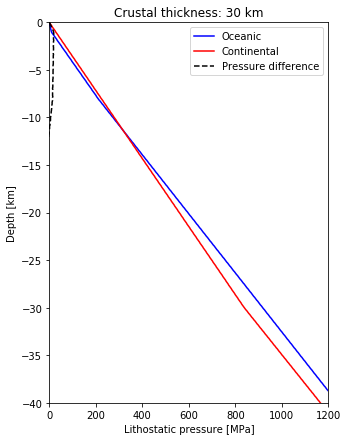

Maximum pressure difference: 19 MPa


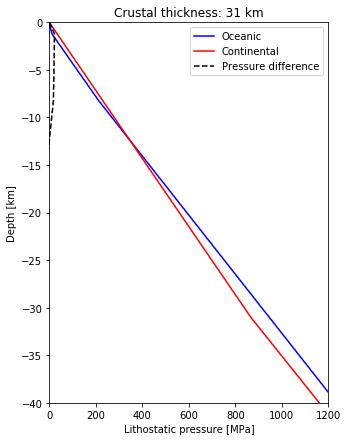

Maximum pressure difference: 23 MPa


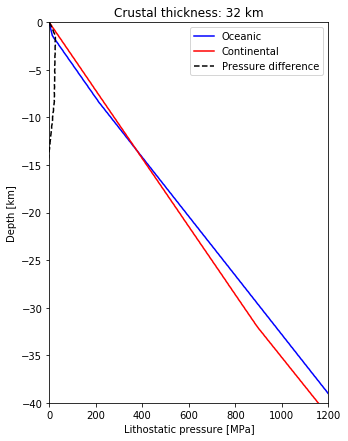

Maximum pressure difference: 26 MPa


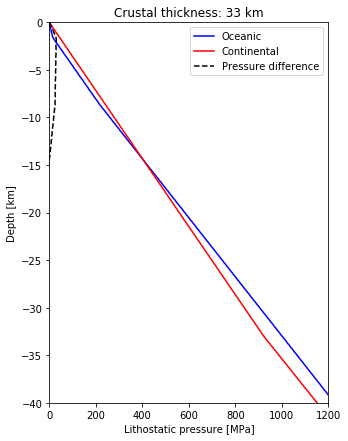

Maximum pressure difference: 30 MPa


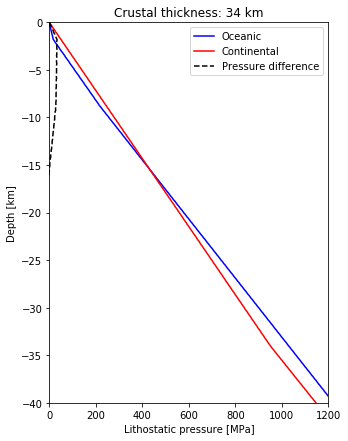

Maximum pressure difference: 33 MPa


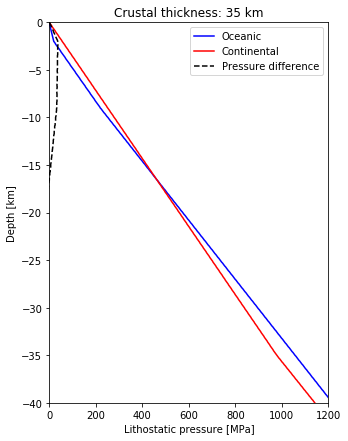

Maximum pressure difference: 37 MPa


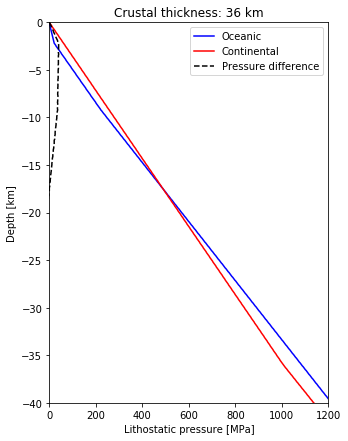

Maximum pressure difference: 40 MPa


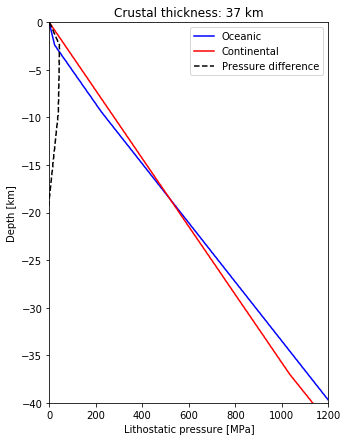

Maximum pressure difference: 44 MPa


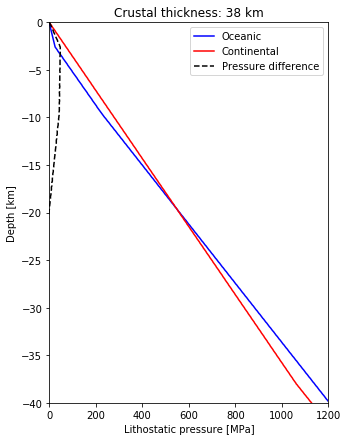

Maximum pressure difference: 47 MPa


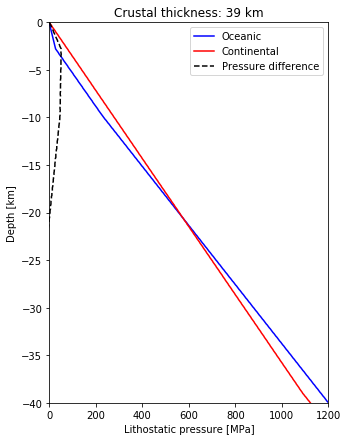

Maximum pressure difference: 51 MPa


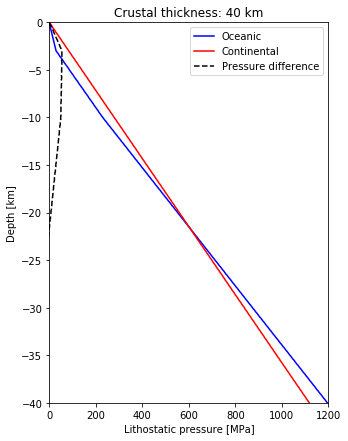

Maximum pressure difference: 54 MPa


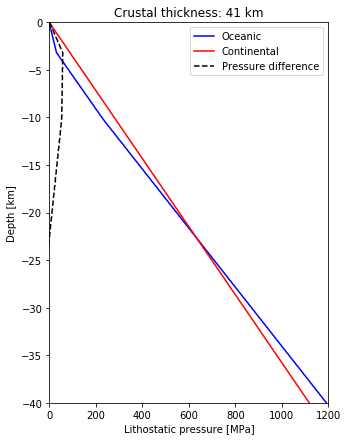

Maximum pressure difference: 58 MPa


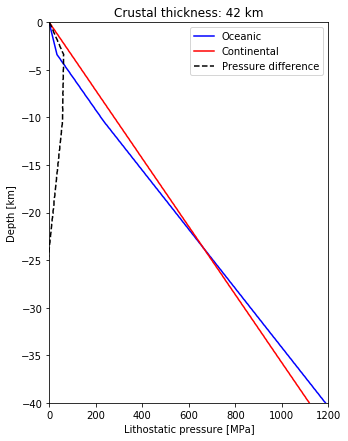

Maximum pressure difference: 62 MPa


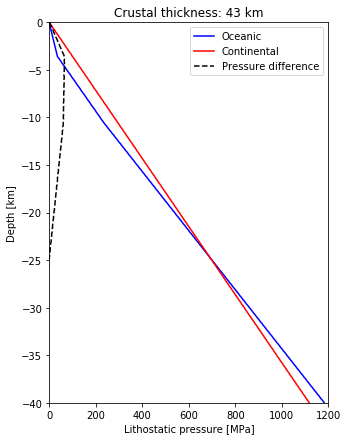

Maximum pressure difference: 65 MPa


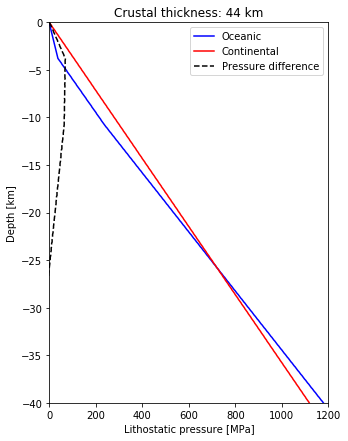

Maximum pressure difference: 69 MPa


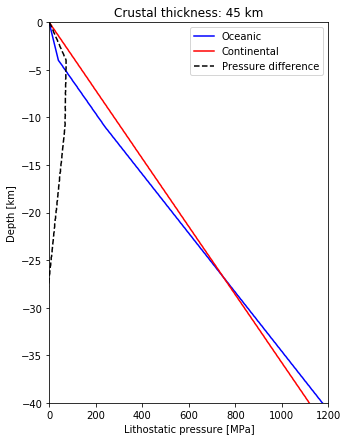

Maximum pressure difference: 72 MPa


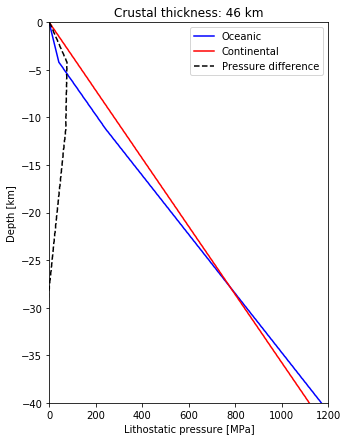

Maximum pressure difference: 76 MPa


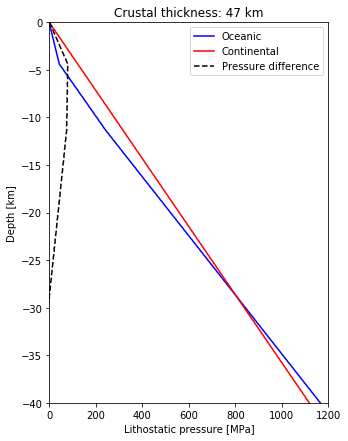

Maximum pressure difference: 80 MPa


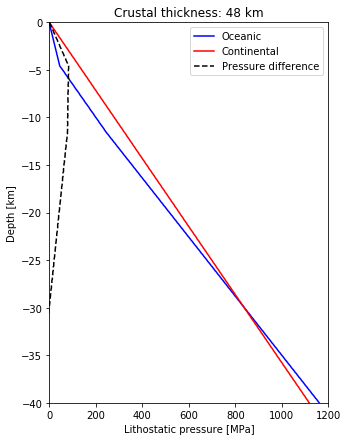

Maximum pressure difference: 83 MPa


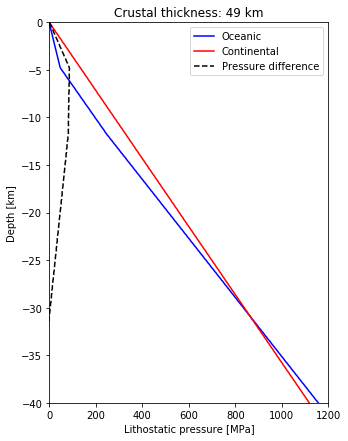

Maximum pressure difference: 87 MPa


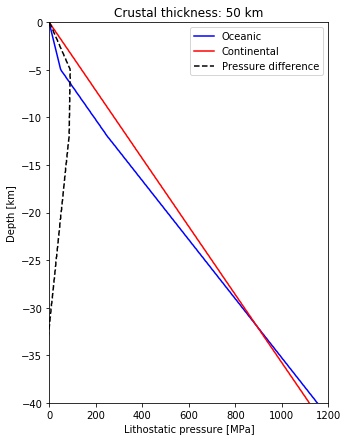

Maximum pressure difference: 90 MPa


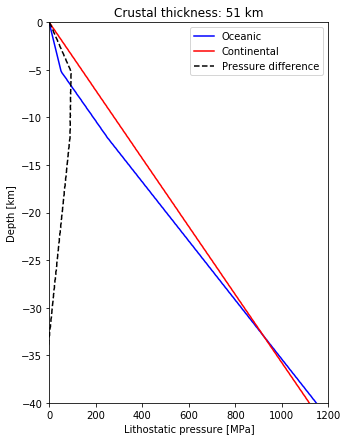

Maximum pressure difference: 94 MPa


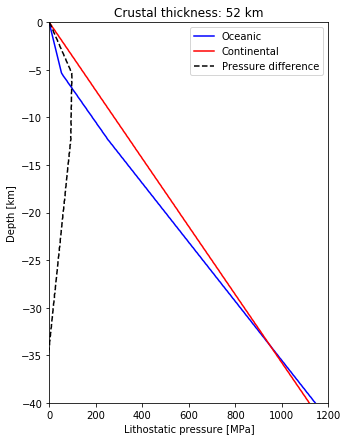

Maximum pressure difference: 97 MPa


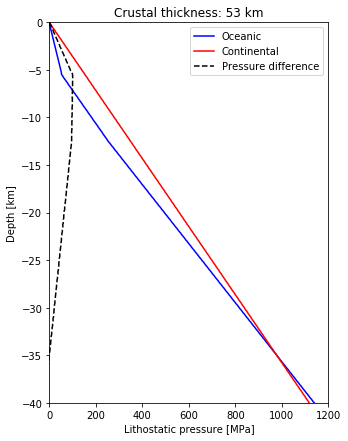

Maximum pressure difference: 101 MPa


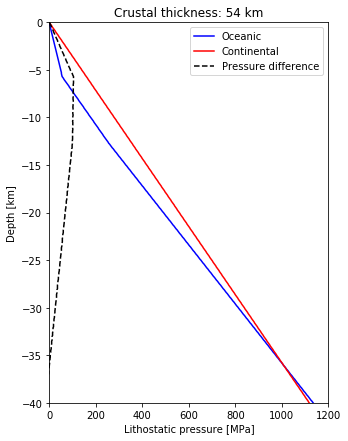

Maximum pressure difference: 104 MPa


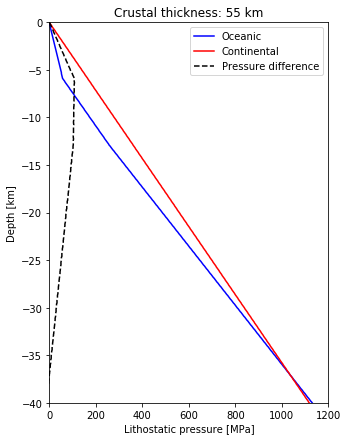

Maximum pressure difference: 108 MPa


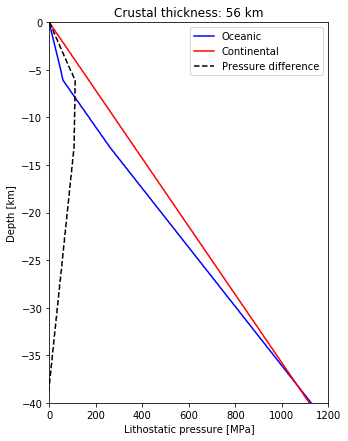

Maximum pressure difference: 111 MPa


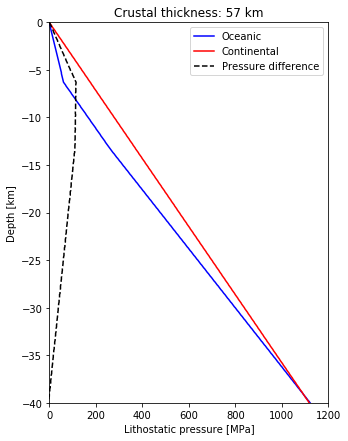

Maximum pressure difference: 115 MPa


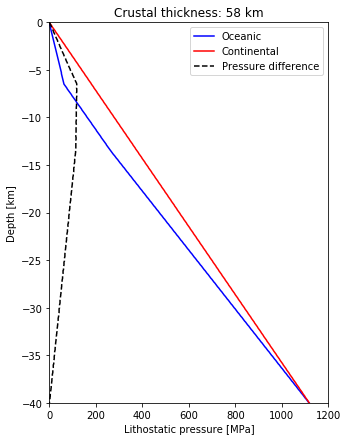

Maximum pressure difference: 118 MPa


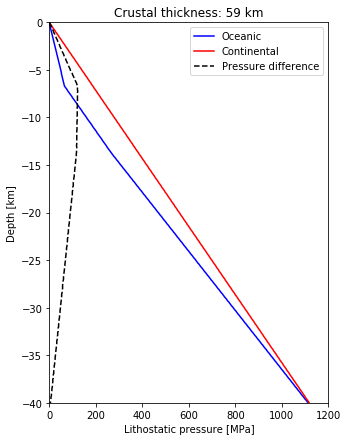

Maximum pressure difference: 122 MPa


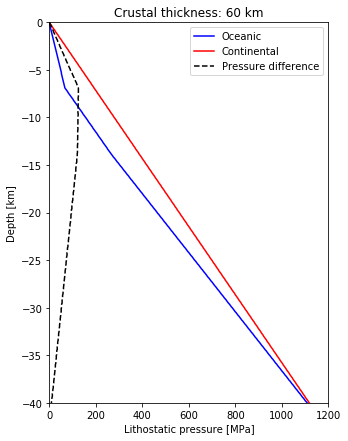

Maximum pressure difference: 125 MPa


In [14]:
P_A, P_B, P_diff = ([[]]*len(cc) for i in range(3))

for i, c in enumerate(cc):
    P_A[i] = calc_pressure_continent(z[i], w_A, c, rho_cm, rho_m)
    P_B[i] = calc_pressure_ocean(z[i], w_B[i], oc, rho_oc, rho_om, rho_m)
    plt.figure(figsize=(5,7))
    plt.plot(P_B[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A[i],[-j/1000 for j in z[i]],'r-')
    P_diff[i] = P_A[i]-P_B[i] 
    plt.plot(P_diff[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff[i]))

### Archean Earth

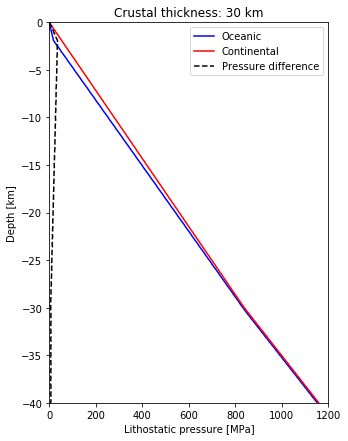

Maximum pressure difference: 35 MPa


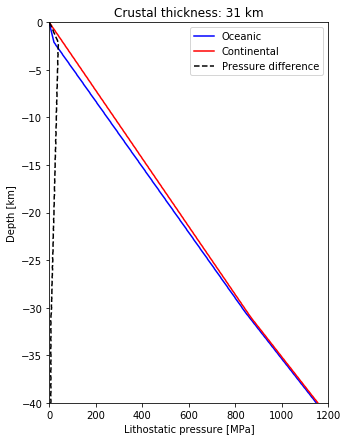

Maximum pressure difference: 39 MPa


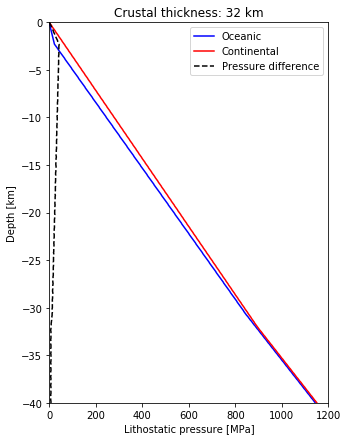

Maximum pressure difference: 42 MPa


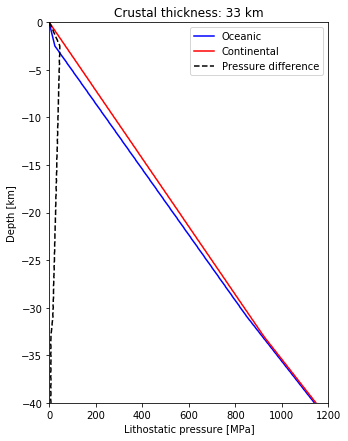

Maximum pressure difference: 45 MPa


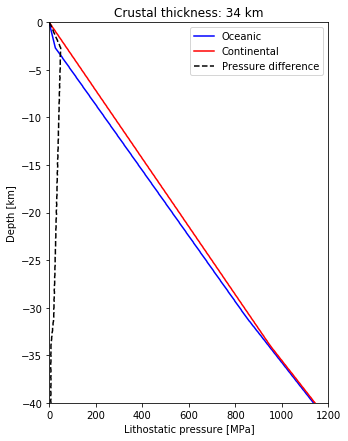

Maximum pressure difference: 49 MPa


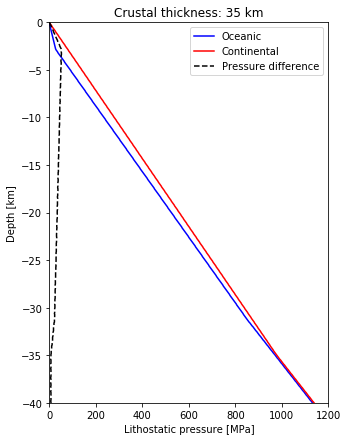

Maximum pressure difference: 52 MPa


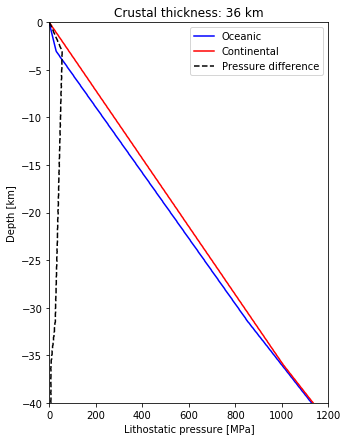

Maximum pressure difference: 55 MPa


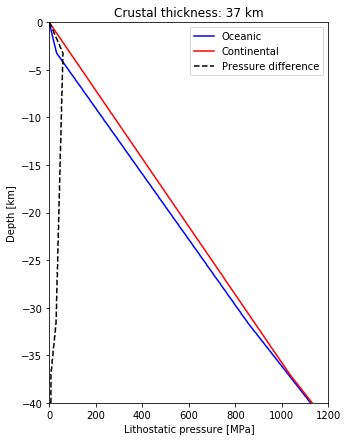

Maximum pressure difference: 59 MPa


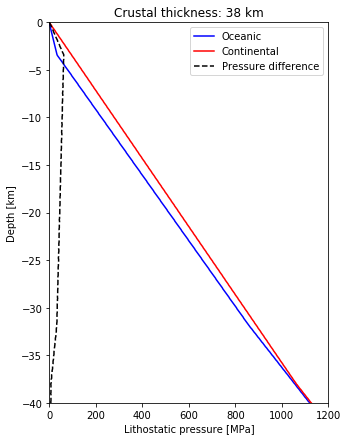

Maximum pressure difference: 62 MPa


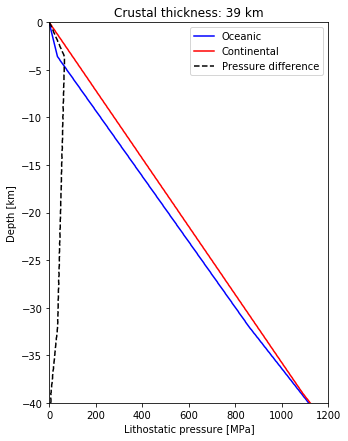

Maximum pressure difference: 65 MPa


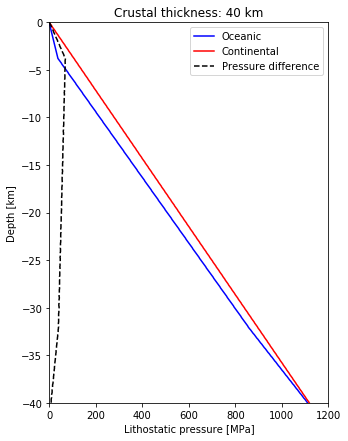

Maximum pressure difference: 69 MPa


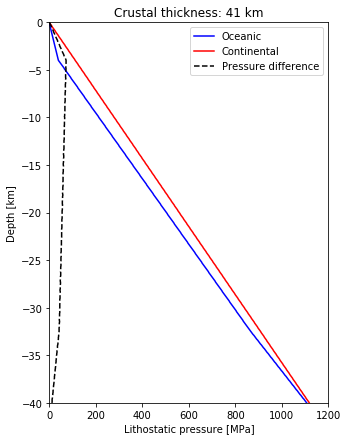

Maximum pressure difference: 72 MPa


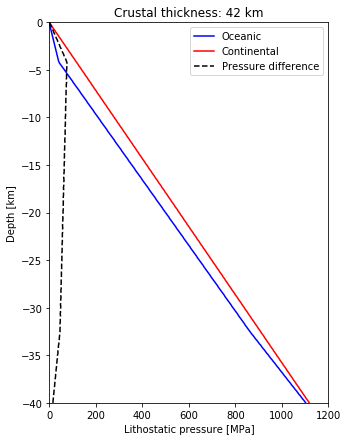

Maximum pressure difference: 76 MPa


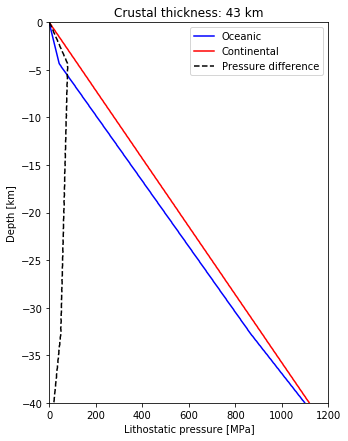

Maximum pressure difference: 79 MPa


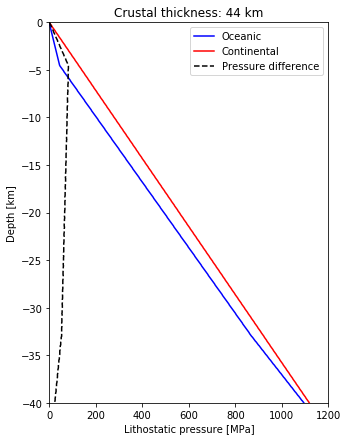

Maximum pressure difference: 82 MPa


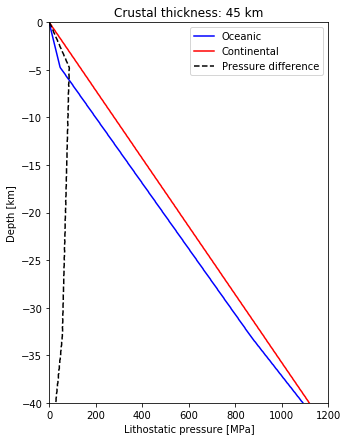

Maximum pressure difference: 86 MPa


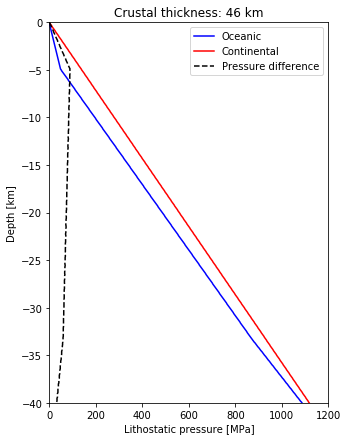

Maximum pressure difference: 89 MPa


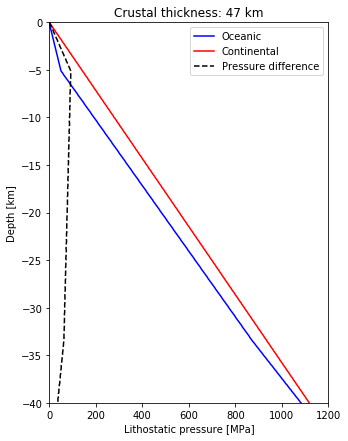

Maximum pressure difference: 92 MPa


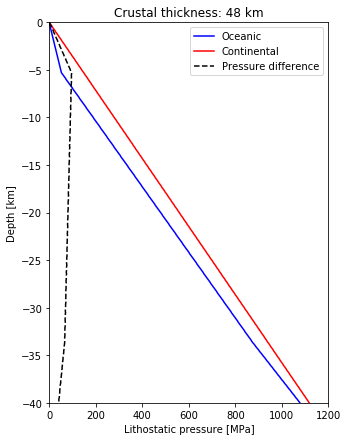

Maximum pressure difference: 96 MPa


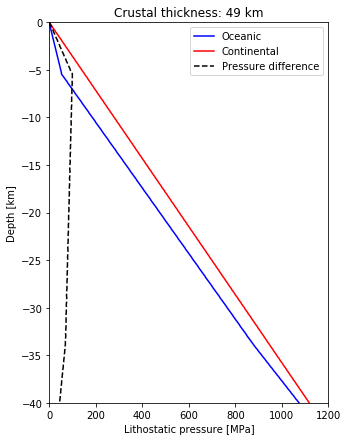

Maximum pressure difference: 99 MPa


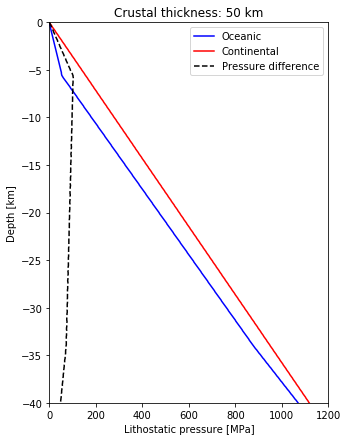

Maximum pressure difference: 103 MPa


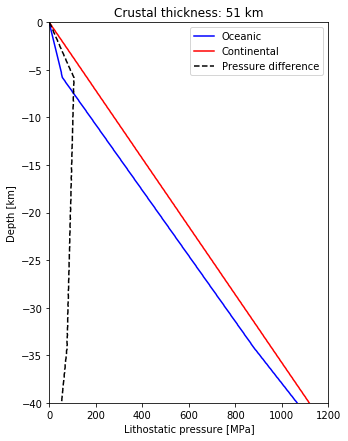

Maximum pressure difference: 106 MPa


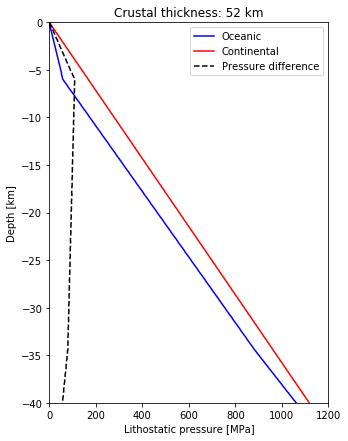

Maximum pressure difference: 109 MPa


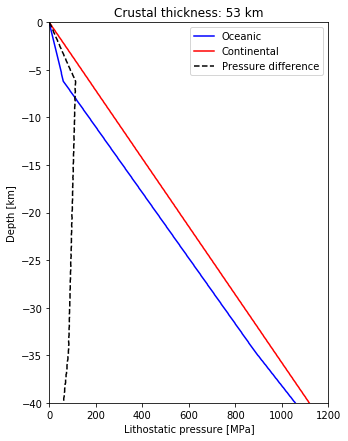

Maximum pressure difference: 113 MPa


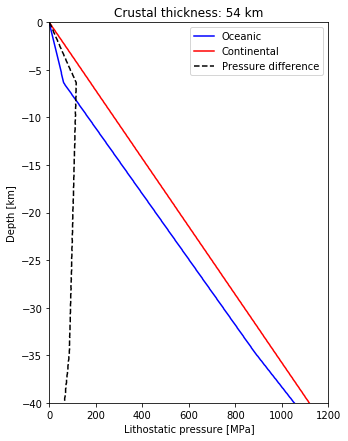

Maximum pressure difference: 116 MPa


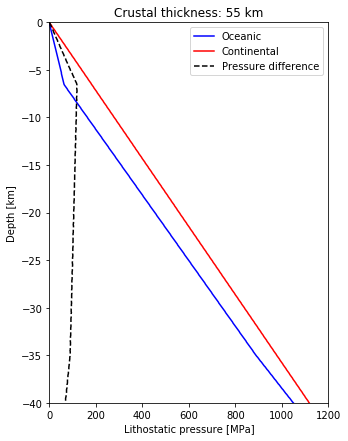

Maximum pressure difference: 119 MPa


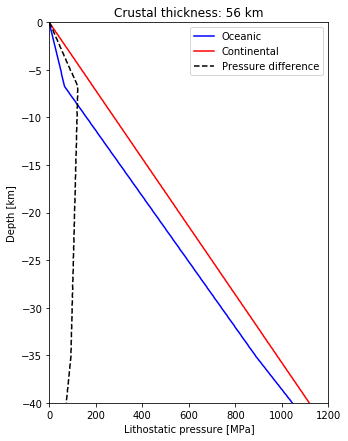

Maximum pressure difference: 123 MPa


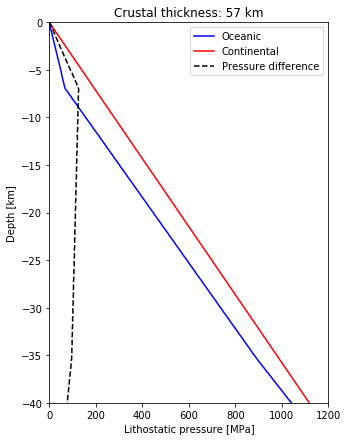

Maximum pressure difference: 126 MPa


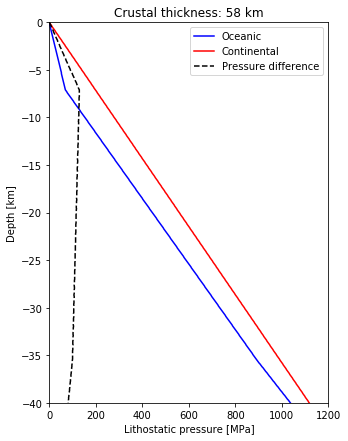

Maximum pressure difference: 129 MPa


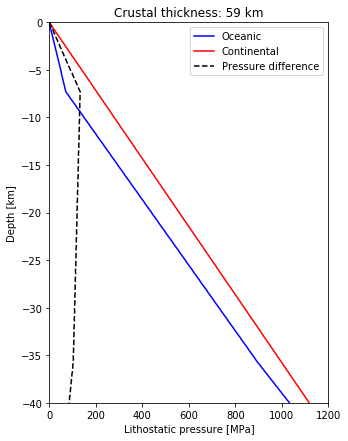

Maximum pressure difference: 133 MPa


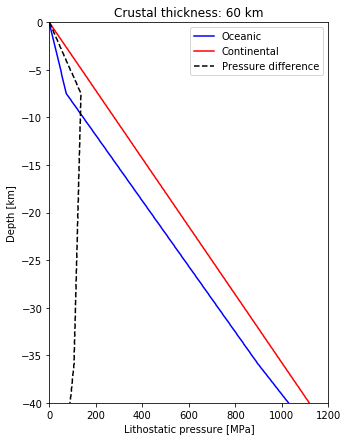

Maximum pressure difference: 136 MPa


In [15]:
# assuming that continents are at sea level
P_A_archean, P_B_archean, P_diff_archean = ([[]]*len(cc) for i in range(3))

for i, c in enumerate(cc):
    P_A_archean[i] = calc_pressure_continent(z[i], w_A, c, rho_cm_archean, rho_m_archean)
    P_B_archean[i] = calc_pressure_ocean(z[i], w_B_archean[i], oc_archean, rho_oc_archean, rho_om_archean, rho_m_archean)
    plt.figure(figsize=(5,7))
    plt.plot(P_B_archean[i],[-j/1000 for j in z[i]],'b-')
    plt.plot(P_A_archean[i],[-j/1000 for j in z[i]],'r-')
    P_diff_archean[i] = P_A_archean[i]-P_B_archean[i] 
    plt.plot(P_diff_archean[i],[-j/1000 for j in z[i]],'k--')
    plt.ylim((-40,0))
    plt.xlim((0,1200))
    plt.title('Crustal thickness: %i km'%(cc[i]/1000))
    plt.xlabel('Lithostatic pressure [MPa]')
    plt.ylabel('Depth [km]')
    plt.legend(['Oceanic','Continental','Pressure difference'])
    plt.show()
    print("Maximum pressure difference: %i MPa"%max(P_diff_archean[i]))

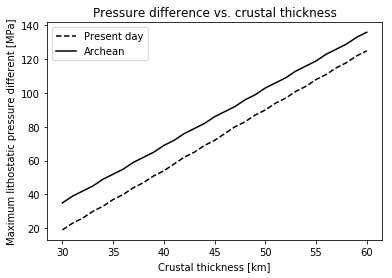

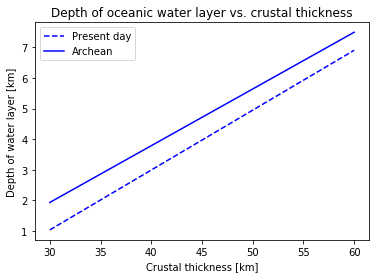

In [16]:
P_diff_max_archean = []*len(cc)
P_diff_max = []*len(cc)

for i in P_diff:
    P_diff_max.append(max(i))
    # print(P_diff_max)
for i in P_diff_archean:
    P_diff_max_archean.append(max(i))
    # print(P_diff_max)

plt.plot(cc/1000,np.array(P_diff_max),'k--')
plt.plot(cc/1000,np.array(P_diff_max_archean),'k-')
plt.ylabel('Maximum lithostatic pressure different [MPa]')
plt.xlabel('Crustal thickness [km]')
plt.legend(["Present day","Archean"])
plt.title("Pressure difference vs. crustal thickness")
plt.show()

plt.plot(cc/1000,w_B/1000,'b--')
plt.plot(cc/1000,w_B_archean/1000,'b')
plt.ylabel('Depth of water layer [km]')
plt.xlabel('Crustal thickness [km]')
plt.legend(["Present day","Archean"])
plt.title("Depth of oceanic water layer vs. crustal thickness")
plt.show()

In [17]:
# saving just the continental thickness value for which there is a positive pressure difference
# zipping 2 lists into tuples, so differential pressures are associated with their respective continential thickness
P_archean = [i for i in list(map(lambda x, y:(x,y), P_diff_archean, cc)) if i[:][0][1]>0]

data_P = [list(map(lambda x, y:(x,y), P_diff, cc)), P_archean]

## Calculating the geothermal gradient
The geothermal gradient is calculated for the present-day and Archean Earth. This defines the depth-temperature profile of the upper crust. Where the previous section was used to constrain a $\sigma$ regime for crustal deformation, the geothermal gradient will be used to constrain the $T$ regime.

### Rate of radiogenic heat production $H$
#### Present day Earth

In [18]:
K_con = ((1.5*10**4)/10**6)
K40_con = (1.28/10**4)*K_con
U_con = (1.3/10**6)
U238_con = 0.9927*U_con
U235_con = 0.0072*U_con
Th_con = (5.6/10**6)

K_heat = (2.79/10**5)*K40_con
U238_heat = (9.37/10**5)*U238_con
U235_heat = (5.69/10**4)*U235_con
Th_heat = (2.69/10**5)*Th_con

H = K_heat+Th_heat+U238_heat+U235_heat # rate of radiogenic heat production [W/kg]
print("Rate of radiogenic heat production: %.2e [W/Kg]"%H)

Rate of radiogenic heat production: 3.30e-10 [W/Kg]


#### Archean Earth

In [19]:
t = 3.5 # [Gyr]
K_con = ((1.5*10**4)/10**6)
K40_con = (1.28/10**4)*K_con*math.exp(0.555*t)

U_con = (1.3/10**6)
U238_con = 0.9927*U_con*math.exp(0.155*t)
U235_con = 0.0072*U_con*math.exp(0.985*t)

Th_con = (5.6/10**6)*math.exp(0.0495*t)

K_heat = (2.79/10**5)*K40_con
U238_heat = (9.37/10**5)*U238_con
U235_heat = (5.69/10**4)*U235_con
Th_heat = (2.69/10**5)*Th_con

H_archean = K_heat+Th_heat+U238_heat+U235_heat # rate of radiogenic heat production [W/kg]
print("H(t) at t = %.1f Ga: %.2e [W/Kg]"%(t, H_archean))

H(t) at t = 3.5 Ga: 9.28e-10 [W/Kg]


### Calculating the geotherm
Starting with the heat equation
$$0 = k\frac{d^2T}{dz^2}+\rho H$$

where $H$ is rate of internal heat production ($W/kg$).

Integrate to get:
$$C = k\frac{dT}{dz}+\rho Hz$$

Integrate again:
$$D+Cz = kT + \frac{1}{2}\rho Hz^2$$

$$T = \frac{Cz}{k}-\frac{1}{2k}\rho Hz^2 + \frac{D}{k}$$

From the boundary condition that $T(z=0) = 0$, we have $D = 0$. The temperature gradient within the continental crust is:

$$T_1 = \frac{C_1}{k_1}z_1-\frac{1}{2k_1}\rho_1 Hz_1^2$$

where $C_1$ is the surface heat flow (from boundary condition $z = 0$)

The temperature at the base of the continental lithosphere is:
$$T_m = T_p + (d_{cc}+d_{cm})\left(\frac{\partial T}{\partial z}\right)$$

where the temperature potential of the mantle $T_p$ is $\sim 1350^{\circ}$C (now) and $1600^{\circ}$C (Archean) and the adiabatic gradient $\left(\frac{\partial T}{\partial z}\right) \sim 0.5$ K/km.

In [20]:
T_p = 1350 # potential temperature for the current Earth [C]
T_p_archean = 1600 # potential temperature of the Archean earth [C]
dT_dz = 0.5 # adiabatic gradient [K/km]
T_m = T_p + (cc+cm)/1000*dT_dz
T_m_archean = T_p_archean + (cc+cm)/1000*dT_dz
# print("Assuming continental crustal thickness of %i [km] and continental lithospheric mantle thickness of %i [km]"%((cc/1000),(cm/1000)))
print(f"Assuming a continental lithospheric mantle thickness of {cm/1000} km")
print(f"Range of continental crustal thickness [km]:")
for i in cc:
    print(f"{i/1000:0.2f}")
print(f"Mantle temperature [C]:")
for i in T_m:
    print(f"{i:.0f}")
print(f"Archean mantle temperature [C]:")
for i in T_m_archean:
    print(f"{i:.0f}")

Assuming a continental lithospheric mantle thickness of 200.0 km
Range of continental crustal thickness [km]:
30.00
31.00
32.00
33.00
34.00
35.00
36.00
37.00
38.00
39.00
40.00
41.00
42.00
43.00
44.00
45.00
46.00
47.00
48.00
49.00
50.00
51.00
52.00
53.00
54.00
55.00
56.00
57.00
58.00
59.00
60.00
Mantle temperature [C]:
1465
1466
1466
1466
1467
1468
1468
1468
1469
1470
1470
1470
1471
1472
1472
1472
1473
1474
1474
1474
1475
1476
1476
1476
1477
1478
1478
1478
1479
1480
1480
Archean mantle temperature [C]:
1715
1716
1716
1716
1717
1718
1718
1718
1719
1720
1720
1720
1721
1722
1722
1722
1723
1724
1724
1724
1725
1726
1726
1726
1727
1728
1728
1728
1729
1730
1730


The temperature gradient below the continental crust is:
$$T_2 = \frac{C_2}{k_2}z_2+D_2$$

We have three unknowns ($C_1$, $C_2$, $D_2$) and three boundary conditions.

At $z_1 = z_2 = d_{cc}$, we require that:
$$T_1 = T_2$$

$$k_1\frac{dT_1}{dz_1} = k_2\frac{dT_2}{dz_1}$$

at $z_2 = d_{cc}+d_{cm}$, we have:
$$T_2 = T_m$$

1) Using $k_1\frac{dT_1}{dz_1} = k_2\frac{dT_2}{dz_1}$:

$$C_1-\rho_1 Hz\Bigg\vert_{z = z_1} = C_2\Bigg\vert_{z=z_1}$$

$$C_1-\rho_1 Hz_1 = C_2$$

2) Using $T_1 = T_2$:
$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho_1 Hz_1^2 = \frac{C_2}{k_2}z_1 + D_2$$

3) Using $T_2 = T_m$:
$$\frac{C_2}{k_2}z_2 + D_2 = T_m$$

Combining (2) and (3):
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho_1 Hz_1^2 = \frac{C_2}{k_2}z_1 + T_m - \frac{C_2}{k_2}z_2$$

Writing $C_1$ in terms of $C_2$:
$$C_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho_1 Hz_1$$

Solving for $C_2$ in (1):
$$C_1 = C_2 +\rho_1 Hz_1$$

$$C_2 + \rho_1 Hz_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho_1 Hz_1$$

$$C_2 - \frac{C_2k_1}{k_2} + \frac{C_2k_1}{k_2}\frac{z_2}{z_1}= \frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1$$


$$C_2\left(1 - \frac{k_1}{k_2} + \frac{k_1}{k_2}\frac{z_2}{z_1}\right) = \frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1$$

$$C_2 = \frac{\left(\frac{T_mk_1}{z_1} - \frac{1}{2}\rho_1 Hz_1\right)}{\left(1 - \frac{k_1}{k_2} + \frac{k_1}{k_2}\frac{z_2}{z_1}\right)}$$

In [21]:
numerator = (T_m*k_1)/cc - (1/2)*rho_cc*H*cc
denominator = 1 - (k_1/k_2) + (k_1/k_2)*((cc+cm)/cc)
C_2 = numerator/denominator

print("C_2:")
for i in C_2:
    print(f"{i:0.3f}")
numerator = (T_m_archean*k_1)/cc - (1/2)*rho_cc*H_archean*cc
denominator = 1 - (k_1/k_2) + (k_1/k_2)*((cc+cm)/cc)
C_2_archean = numerator/denominator
print("C_2 Archean:")
for i in C_2_archean:
    print(f"{i:0.3f}")

C_2:
0.017
0.017
0.017
0.017
0.016
0.016
0.016
0.016
0.016
0.015
0.015
0.015
0.015
0.015
0.014
0.014
0.014
0.014
0.013
0.013
0.013
0.013
0.013
0.012
0.012
0.012
0.012
0.011
0.011
0.011
0.011
C_2 Archean:
0.017
0.017
0.016
0.016
0.015
0.015
0.015
0.014
0.014
0.013
0.013
0.012
0.012
0.011
0.011
0.010
0.010
0.009
0.009
0.008
0.007
0.007
0.006
0.006
0.005
0.005
0.004
0.003
0.003
0.002
0.002


calculating $C_1$ from $C_2$:
$$C_1 = C_2 +\rho_1 Hz_1$$

In [22]:
C_1 = C_2+rho_cc*H*cc
print("C_1 (surface heat flow):")
for i in C_1:
    print(f"{i:0.3f}")
C_1_archean = C_2_archean+rho_cc*H_archean*cc
print("C_1 archean:")
for i in C_1_archean:
    print(f"{i:0.3f}")

C_1 (surface heat flow):
0.046
0.046
0.047
0.048
0.049
0.049
0.050
0.051
0.051
0.052
0.053
0.054
0.054
0.055
0.056
0.057
0.057
0.058
0.059
0.059
0.060
0.061
0.061
0.062
0.063
0.064
0.064
0.065
0.066
0.066
0.067
C_1 archean:
0.097
0.099
0.101
0.103
0.105
0.108
0.110
0.112
0.114
0.116
0.118
0.121
0.123
0.125
0.127
0.129
0.131
0.133
0.136
0.138
0.140
0.142
0.144
0.146
0.148
0.150
0.152
0.154
0.156
0.158
0.160


calculating $D$ from $C_2$:
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

In [23]:
D_2 = T_m-(C_2*(cm))/k_2
print("D_2 [K]:")
for i in D_2:
    print(f"{i:0.0f}")
D_2_archean = T_m_archean-(C_2_archean*(cm))/k_2
print("D_2 archean [K]:")
for i in D_2_archean:
    print(f"{i:0.0f}")

D_2 [K]:
314
327
341
354
368
382
396
411
425
440
454
469
484
499
515
530
545
561
577
593
609
625
641
658
674
691
708
725
742
759
776
D_2 archean [K]:
569
597
626
655
685
715
746
778
809
842
875
908
941
976
1010
1045
1081
1117
1153
1190
1227
1264
1302
1341
1379
1419
1458
1498
1538
1579
1620


In [24]:
def calc_geotherm(z,cc,C_1,C_2,D_2,H):
    """
    Calculates the geothermal gradient.
    z: depth [m]
    cc: continental crustal layer thickness [m]
    C_1: surface heat flow
    C_2: internal heat flow (?)
    D_2: constant [K] 
    H: radiogenic heat flow [W/kg]
    """
    T = np.ones(len(z))
    T_0 = 273 # surface temperature [K]
    
    # index of end of crustal layer
    i = int(np.where(z==cc)[0])
    # temperature within the crust 
    for j, z_1 in enumerate(z[:i]):
        T[j] = T_0 + (C_1*z_1)/k_1  - ((rho_cc*H*(math.pow(z_1,2)))/(2*k_1))
    # temperature below the crust
    for m, z_2 in enumerate(z[i:]):
        T[m+j+1] = ((z_2-cc)/k_2)*C_2 + D_2 + T_0
    return T

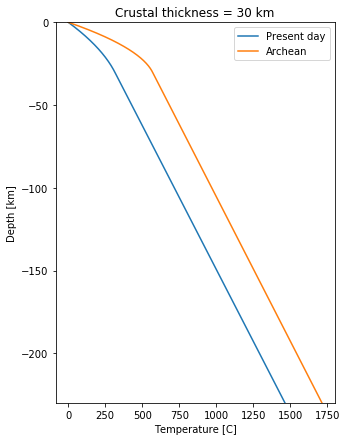

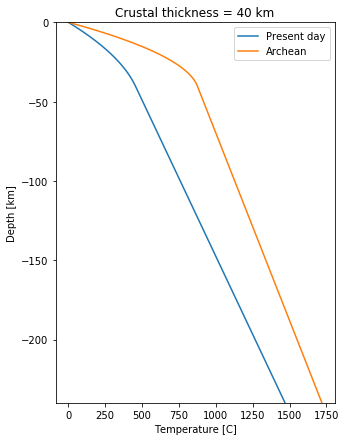

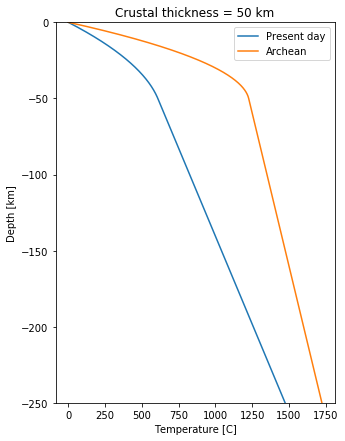

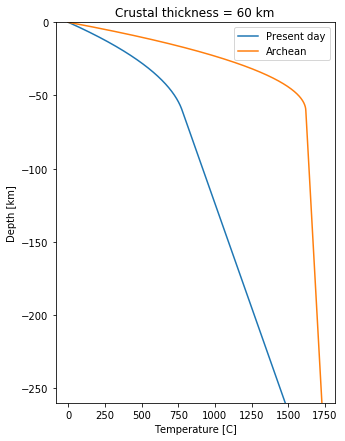

In [25]:
z, T, T_archean = ([[]]*len(cc) for i in range(3)) # depth [m]
z = [np.array(range(INITIAL_DEPTH,i+cm,DEPTH_INCREMENT)) for i in cc]

for i in range(len(cc)):
    T[i] = calc_geotherm(z[i],cc[i],C_1[i],C_2[i],D_2[i],H)
    T_archean[i] = calc_geotherm(z[i],cc[i],C_1_archean[i],C_2_archean[i],D_2_archean[i],H_archean)
    if (i%10==0):
        plt.figure(figsize=(5,7))
        plt.plot(T[i]-273,[-j/1000 for j in z[i]])
        plt.plot(T_archean[i]-273,[-j/1000 for j in z[i]])
        plt.ylim((-z[i][-1]/1000,0))
        plt.title(f"Crustal thickness = {cc[i]/1000:0.0f} km")
        plt.xlabel('Temperature [C]')
        plt.ylabel('Depth [km]')
        plt.legend(['Present day','Archean'])
        plt.show()

## Calculating the IQR for a Monte Carlo ensemble

### Data processing

In [26]:
# file names and the list of parameters associated with each column
names = ["rutter04ab_X.out","GT95_d_fixed.out","LP92_COH.out","fukuda18_d_fixed.out"]
names_shortened = ['RB04','GT95','LP92','F18']

file_names = {
    "rutter04ab_X.out":"run_id chi2(simplified) chi2(original) m Q_dif n Q_dis X X1 A_dif A_dis",
    "GT95_d_fixed.out":"run_id chi2(simplified) chi2(original) m Q_dif n Q_dis X X1 X2 X3 X4 A_dif A_dis",
    "LP92_COH.out":"run_id chi2(simplified) chi2(original) r n Q X X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 X13 A",
    "fukuda18_d_fixed.out":"run_id chi2(simplified) chi2(original) m r_dif Q_dif r_dis n Q_dis X X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 A_dif A_dis"
}
file, data = ([[]]*len(file_names) for i in range(2))

In [27]:
# importing MCMC inversion results
for i,name in enumerate(file_names):
    file[i] = pd.read_csv(name,delim_whitespace=True,names=list(str.split(file_names[names[i]])))

In [28]:
for i, df in enumerate(file):
    # drop interrun biases
    f = df[df.columns.drop(list(df.filter(regex='X')))]
    # skip first 1000 runs, then select sample from every 100 runs
    data[i] = f.iloc[100:-1:10,:]

In [29]:
n=1
print(names_shortened[n])
data[n]

GT95


,run_id,chi2(simplified),chi2(original),m,Q_dif,n,Q_dis,A_dif,A_dis
100,10100,38.352,0.820,1.02160,110462.00,4.03865,148902.0,7.364930e-02,1.089870e-07
110,11100,57.123,1.076,1.17858,364321.00,4.15290,106744.0,1.514840e+09,1.490120e-09
120,12100,56.561,1.130,3.47599,558080.00,3.35333,155908.0,1.498530e+21,7.285610e-06
130,13100,35.840,0.661,1.12619,154516.00,4.00816,166751.0,6.318390e+00,8.714470e-07
140,14100,32.320,0.560,5.41721,8128.94,3.50134,142771.0,5.083140e+03,7.689140e-07
150,15100,37.244,0.509,3.82389,158260.00,3.74634,229647.0,3.367490e+05,1.123280e-03
160,16100,33.821,0.809,1.20280,154508.00,3.69333,135834.0,1.337450e+01,2.412830e-07
170,17100,47.822,0.921,1.19268,178020.00,3.56622,157865.0,8.154690e+01,3.068620e-06
180,18100,27.716,0.369,1.43904,344872.00,3.86414,136708.0,3.933850e+08,1.064280e-07
190,19100,69.242,1.150,4.46649,366806.00,3.83429,207322.0,5.653770e+15,8.017590e-05


In [30]:
# Unzipping results from the previous sections

present_day = data_P[0]
P_diff_present = [i[0] for i in present_day]
cc_present = [i[1] for i in present_day]
sigma = np.array(P_diff_present) # differential pressure [MPa]

archean = data_P[1]
P_diff_archean = [i[0] for i in archean]
cc_archean = [i[1] for i in archean]
sigma_archean = P_diff_archean

### Calculating IQR

In [31]:
def calc_IQR_dis(data, T, sigma, flow_law="composite",water=0, V=False):
    """
    Calculates the interquartile range for dislocation flow law. Default calculation is for a dry composite inversion.
    data: dataframe of the processed .out file
    flow_law: the target flow law of the inversion ("composite", "dis")
    T: temperature profile [K]
    sigma: pressure profile [MPa]
    V: activation volume (not implemented)
    water: water content or fugacity in [H/Si ppm] or [MPa], respectively. If value is zero, assume dry inversion.
    """
    e, e_50, e_25, e_75, e_mean = ([[[] for j in range(DEPTH)] for i in range(len(sigma))] for i in range(5))
    
    if flow_law=="composite":
        if not water:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A_dis'])*(sigma[j][i]+0.1)**np.array(data['n'])*np.exp(-np.array(data['Q_dis'])/(R*T[j][i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A_dis'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*np.exp(-np.mean(np.array(data['Q_dis']))/(R*T[j][i]))
        else:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A_dis'])*(sigma[j][i]+0.1)**np.array(data['n'])*water**np.array(data['r_dis'])*np.exp(-np.array(data['Q_dis'])/(R*T[j][i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A_dis'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*water**np.mean(np.array(data['r_dis']))*np.exp(-np.mean(np.array(data['Q_dis']))/(R*T[j][i]))
    elif flow_law=="dis":
        if not water:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A'])*(sigma[j][i]+0.1)**np.array(data['n'])*np.exp(-np.array(data['Q'])/(R*T[j][i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*np.exp(-np.mean(np.array(data['Q']))/(R*T[j][i]))
        else:
            for j in range(len(sigma)):
                for i in range(DEPTH):
                    e[j][i] = np.array(data['A'])*(sigma[j][i]+0.1)**np.array(data['n'])*water**np.array(data['r'])*np.exp(-np.array(data['Q'])/(R*T[j][i]))
                    e_mean[j][i] = 10**np.mean(np.log10(np.array(data['A'])))*(sigma[j][i]+0.1)**np.mean(np.array(data['n']))*water**np.mean(np.array(data['r']))*np.exp(-np.mean(np.array(data['Q']))/(R*T[j][i]))
    else:
        print("Flow law not recognized.")
        return 1

    e_25 = [[np.percentile(j,25) for j in i] for i in e]
    e_50 = [[np.percentile(j,50) for j in i] for i in e]
    e_75 = [[np.percentile(j,75) for j in i] for i in e]
    return [e_50, e_25, e_75,e_mean]

In [32]:
IQR, IQR_archean = ([[]]*len(file_names) for i in range(2))

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[0],T, sigma)
IQR[0] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[1],T, sigma)
IQR[1] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[2],T, sigma, flow_law="dis",water=C_OH)
IQR[2] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[3],T, sigma, water=f_H2O)
IQR[3] = [e_50, e_25, e_75, e_mean]

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in power
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power
C:\Program Files\ArcG

In [33]:
e_50, e_25, e_75, e_mean = calc_IQR_dis(data[0],T_archean, sigma_archean)
IQR_archean[0] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[1],T_archean, sigma_archean)
IQR_archean[1] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[2],T_archean, sigma_archean, flow_law="dis",water=C_OH)
IQR_archean[2] = [e_50, e_25, e_75, e_mean]

e_50, e_25, e_75, e_mean = calc_IQR_dis(data[3],T_archean, sigma_archean, water=f_H2O)
IQR_archean[3] = [e_50, e_25, e_75, e_mean]

## Modeling crustal strength
Here we assume that deformation in the upper crust occurs primarily through dislocation motion, the general form for which is defined as:
$$\dot\epsilon = \sigma^nf_{H_2O}^r\exp(-\tfrac{Q}{RT})$$
In the first two sections, we derived the $\sigma$ and $T$ profiles for deformation in the upper crust. Flow law parameters ($n$,$r$, $Q$) were simultaneously resolved from the inversion.

This section combines these results to put our inversion results into geologic context. Strength profiles are predicted using inversion results from a number of experimental datasets extrapolated into geologic conditions.

### Present day

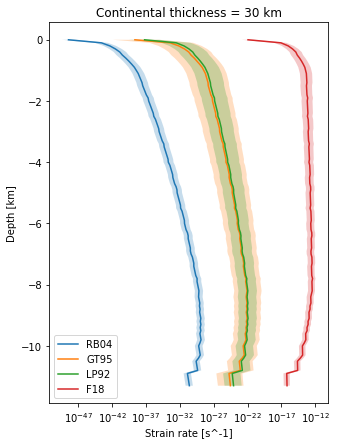

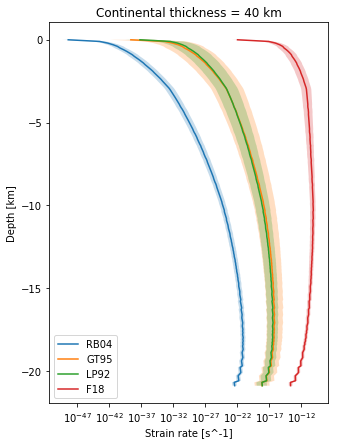

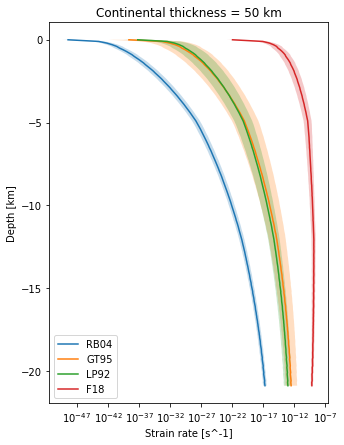

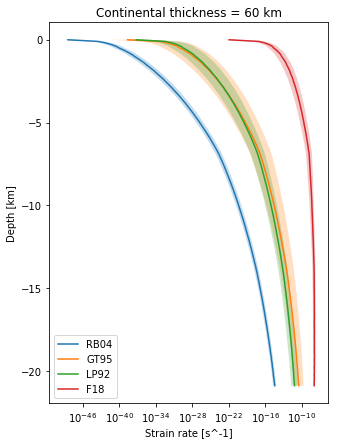

In [34]:
for j in range(len(sigma)):
    if (j%10==0):
        plt.figure(figsize=(5,7))
    for i,iqr in enumerate(IQR):
        if (j%10==0):
            #F18_GBS = 10**(-2.97)*sigma**(1.7)*d**(0.51)*f_H2O*np.exp(183000/(R*T[j][:DEPTH]))
            #plt.semilogx(np.ones(np.shape(iqr[0][j]))*F18_gbs,-z[j][:DEPTH]/1000)
            plt.semilogx(iqr[0][j],-z[j][:DEPTH]/1000)
            plt.fill_betweenx(-z[j][:DEPTH]/1000, iqr[1][j], iqr[2][j], alpha=0.25)
    if (j%10==0):
        #plt.ylim([-(LIMITING_DEPTH/1000-1),0])
        #plt.xlim([10**-32,10**-7])
        plt.title(f"Continental thickness = {cc[j]/1000:0.0f} km")
        plt.xlabel('Strain rate [s^-1]')
        plt.ylabel('Depth [km]')
        plt.legend(names_shortened)    
        plt.show()

In [35]:
np.shape(z)

(31,)

### Archean Earth

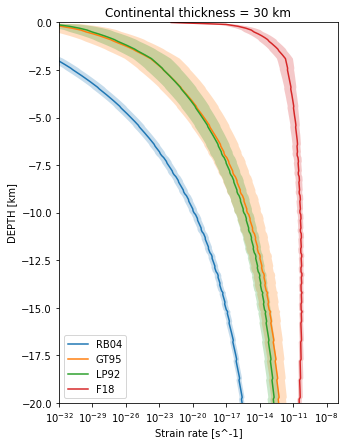

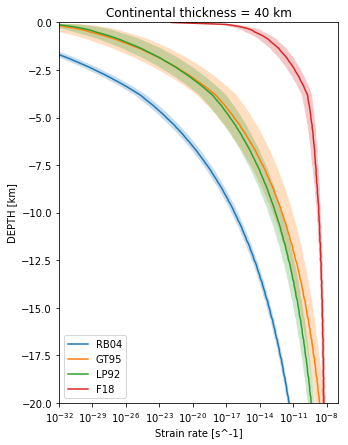

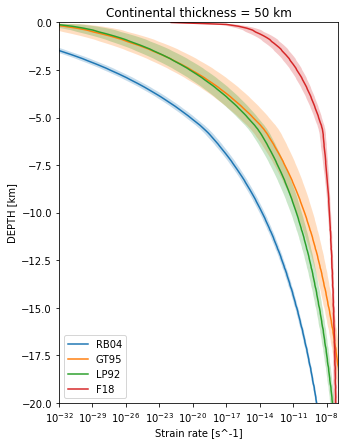

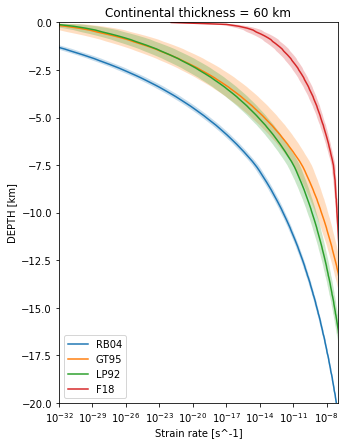

In [36]:
for j in range(len(sigma_archean)):
    if (j%10==0):
        plt.figure(figsize=(5,7))
    for i,iqr in enumerate(IQR_archean):
        if (j%10==0):
            plt.semilogx(iqr[0][j],-z[j][:DEPTH]/1000)
            plt.fill_betweenx(-z[j][:DEPTH]/1000, iqr[1][j], iqr[2][j], alpha=0.25)
    if (j%10==0):
        plt.ylim(-(LIMITING_DEPTH/1000-1),0)
        plt.xlim(10**-32,10**-7)
        plt.title(f"Continental thickness = {cc[j]/1000:0.0f} km")
        plt.xlabel('Strain rate [s^-1]')
        plt.ylabel('DEPTH [km]')
        plt.legend(names_shortened)    
        plt.show()

## Summary

Summary figures for the paper.

### Set variables

In [37]:
names_shortened

['RB04', 'GT95', 'LP92', 'F18']

In [38]:
# Dataset to use for the first summary figure
VAR1 = 1
# Dataset to use for the second summary figure
VAR2 = 1
# Thickness of continental crust to use for the second summary figure
VAR3 = 40000

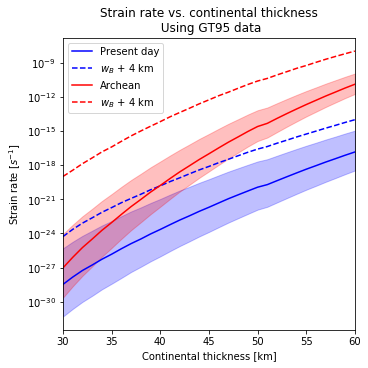

In [39]:
# Using GT95
plt.figure(figsize=(5,5),constrained_layout=True)
# get index of the base of the water layer w_B
base_idx = [int(np.where(z[i]==np.round((w_B[i])/100)*100)[0]) for i in range(len(cc))]

base_idx_0 = [int(np.where(z[i]==np.round((w_B[i]+4000)/100)*100)[0]) for i in range(len(cc))]

plt.title(f"Strain rate vs. continental thickness\n Using {names_shortened[VAR1]} data")
strain_rate_50 = np.array([[IQR[VAR1][0][i][base_idx[i]]] for i in range(len(cc))])
strain_rate_25 = np.array([[IQR[VAR1][1][i][base_idx[i]]] for i in range(len(cc))])
strain_rate_75 = np.array([[IQR[VAR1][2][i][base_idx[i]]] for i in range(len(cc))])
plt.semilogy(cc/1000,strain_rate_50,'b')
plt.semilogy(cc/1000,np.array([[IQR[VAR1][0][i][base_idx_0[i]]] for i in range(len(cc))]),'b--')
plt.fill_between(cc/1000,np.ndarray.flatten(strain_rate_25),np.ndarray.flatten(strain_rate_75), color='b',alpha=0.25)

base_idx_archean = [int(np.where(z[i]==np.round((w_B_archean[i])/100)*100)[0]) for i in range(len(cc))]
strain_rate_50_archean = np.array([[IQR_archean[VAR1][0][i][base_idx[i]]] for i in range(len(cc))])
strain_rate_25_archean = np.array([[IQR_archean[VAR1][1][i][base_idx[i]]] for i in range(len(cc))])
strain_rate_75_archean = np.array([[IQR_archean[VAR1][2][i][base_idx[i]]] for i in range(len(cc))])
plt.semilogy(cc/1000,strain_rate_50_archean,'r')
plt.semilogy(cc/1000,np.array([[IQR_archean[VAR1][0][i][base_idx_0[i]]] for i in range(len(cc))])
,'r--')
plt.fill_between(cc/1000,np.ndarray.flatten(strain_rate_25_archean),np.ndarray.flatten(strain_rate_75_archean), color='r', alpha=0.25)
plt.ylabel('Strain rate [$s^{-1}$]')
plt.xlabel('Continental thickness [km]')  
plt.legend(['Present day','$w_B$ + 4 km','Archean','$w_B$ + 4 km'])
plt.xlim(30,60)
plt.savefig('strain_rate_cc.png')
plt.show()

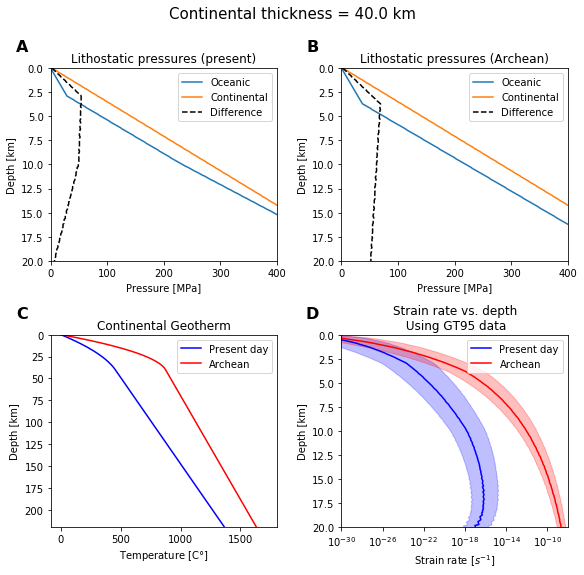

In [41]:
# using Fukuda composite inversion
fig, axs = plt.subplots(2, 2,figsize=(8,8),constrained_layout=True)
fig.gca().invert_yaxis()

# get index for cc = 40 km
idx = int(np.where(cc==VAR3)[0])

axs[0,0].set_title('Lithostatic pressures (present)')
axs[0,0].set_ylabel('Depth [km]')
axs[0,0].set_xlabel('Pressure [MPa]')

axs[0,0].plot(P_B[idx][1:],z[idx]/1000,'tab:blue')
axs[0,0].plot(P_A[idx][1:],z[idx]/1000,'tab:orange')
axs[0,0].plot(P_diff[idx][1:],z[idx]/1000,'k--')
axs[0,0].set_ylim([20,0])
axs[0,0].set_xlim([0,400])
axs[0,0].legend(['Oceanic','Continental','Difference'])

axs[0,1].set_title('Lithostatic pressures (Archean)')
axs[0,1].set_xlabel('Pressure [MPa]')
axs[0,1].set_ylabel('Depth [km]')
axs[0,1].plot(P_B_archean[idx][1:],z[idx]/1000,'tab:blue')
axs[0,1].plot(P_A_archean[idx][1:],z[idx]/1000,'tab:orange')
axs[0,1].plot(P_diff_archean[idx][1:],z[idx]/1000,'k--')
axs[0,1].set_ylim([20,0])
axs[0,1].set_xlim([0,400])
axs[0,1].legend(['Oceanic','Continental','Difference'])

axs[1,0].set_title('Continental Geotherm')
axs[1,0].set_xlabel('Temperature [C$\degree$]')
axs[1,0].set_ylabel('Depth [km]')
axs[1,0].plot(T[idx]-273,z[idx]/1000,'b')
axs[1,0].plot(T_archean[idx]-273,z[idx]/1000,'r')
axs[1,0].set_ylim([220,0])
#axs[1,0].set_xlim([0,400])
axs[1,0].legend(['Present day','Archean'])

axs[1,1].set_title(f"Strain rate vs. depth\n Using {names_shortened[VAR2]} data")
axs[1,1].set_xlabel(r'Strain rate [$s^{-1}$]')
axs[1,1].set_ylabel('Depth [km]')
axs[1,1].semilogx(IQR[VAR2][0][idx],z[idx][:DEPTH]/1000,'b')
axs[1,1].fill_betweenx(z[idx][:DEPTH]/1000, IQR[VAR2][1][idx], IQR[VAR2][2][idx], color='b',alpha=0.25)
axs[1,1].semilogx(IQR_archean[VAR2][0][idx],z[idx][:DEPTH]/1000,'r')
axs[1,1].fill_betweenx(z[idx][:DEPTH]/1000, IQR_archean[VAR2][1][idx], IQR_archean[VAR2][2][idx], color='r',alpha=0.25)
axs[1,1].set_ylim([20,0])
axs[1,1].set_xlim([10**-30,10**-8])
axs[1,1].legend(['Present day','Archean'])

fig.suptitle(f"Continental thickness = {VAR3/1000} km\n",fontsize=15)
for i, label in enumerate(('A', 'B', 'C', 'D')):
    ax = fig.get_axes()[i]
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
plt.savefig('4panel.png')
plt.show()
